## Analyze A/B Test Results

You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).  **Please save regularly

This project will assure you have mastered the subjects covered in the statistics lessons.  The hope is to have this project be as comprehensive of these topics as possible.  Good luck!

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

**As you work through this notebook, follow along in the classroom and answer the corresponding quiz questions associated with each question.** The labels for each classroom concept are provided for each question.  This will assure you are on the right track as you work through the project, and you can feel more confident in your final submission meeting the criteria.  As a final check, assure you meet all the criteria on the [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [2]:
data = pd.read_csv('ab_data.csv')
data.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the below cell to find the number of rows in the dataset.

In [3]:
data.shape

(294478, 5)

> This df has 294478 rows and 5 columns.

c. The number of unique users in the dataset.

In [4]:
data.nunique()

user_id         290584
timestamp       294478
group                2
landing_page         2
converted            2
dtype: int64

> 290584 unique users in the df.

d. The proportion of users converted.

In [5]:
data.converted.sum()/len(data)

0.11965919355605512

> Proportion is about 11.97%.

e. The number of times the `new_page` and `treatment` don't line up.

In [6]:
# Treatment does not line up for old page:
old_t = data[(data['group'] == 'treatment') & (data['landing_page'] == 'old_page')]

# Treatment does not line up for new page:
new_t = data[(data['group'] == 'control') & (data['landing_page'] == 'new_page')]

# Add the lengths:
misaligned = len(old_t) + len(new_t)

misaligned

3893

> They don't line up 3893 times.

f. Do any of the rows have missing values?

In [7]:
data.isnull().any()

user_id         False
timestamp       False
group           False
landing_page    False
converted       False
dtype: bool

> None of them have missing values.

`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to provide how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [8]:
# Storing data in new df2
df2 = data

# Creating new Df:
misaligned_df = pd.concat([old_t, new_t])

# Removing misaligned rows
misaligned_index = misaligned_df.index
df2 = df2.drop(misaligned_index)

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [9]:
df2.user_id.nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [10]:
df2[df2.user_id.duplicated()]


,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


c. What is the row information for the repeat **user_id**? 

In [11]:
df2[df2['user_id'] == 773192]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [12]:
df2.drop(labels = 1899, axis = 0, inplace = True)

`4.` Use **df2** in the below cells to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [13]:
df2.converted.mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [14]:
df2[df2['group'] == 'control']['converted'].mean()

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [15]:
df2[df2['group'] == 'treatment']['converted'].mean()

0.11880806551510564

d. What is the probability that an individual received the new page?

In [16]:
df2['landing_page'].value_counts()[0]/len(df2)

0.50006194422266881

e. Use the results in the previous two portions of this question to suggest if you think there is evidence that one page leads to more conversions?  Write your response below.

According to our calculations, the control group converted at a higher rate than the treatment group but at a very meager rate of ~0.2%. Such small magnitutde may not tantamount to evidence for the superiority of the former over the latter. The difference really is too little to provide any conclusive answer. 

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

$H_{0}$: $P_{new}$ - $P_{old}$ <= 0

$H_{1}$: $P_{new}$ - $P_{old}$ > 0

Single tailed hypothesis:

Null Hypothesis: The difference between the conversion rate of users of the new page versus the old page will be equal to or very close to 0.

Alternate Hypothesis: The difference between the conversion rate of users of the new page versus the old page will be greater than 0 i.e. significant.

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **convert rate** for $p_{new}$ under the null? 

In [17]:
p_new = df2['converted'].mean()
p_new

0.11959708724499628

b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [18]:
# Since we assume no difference under the null
p_old = df2['converted'].mean()
p_old

0.11959708724499628

c. What is $n_{new}$?

In [19]:
df2['landing_page'].value_counts()

new_page    145310
old_page    145274
Name: landing_page, dtype: int64

> $n_{new}$ = 145310

d. What is $n_{old}$?

In [20]:
df2['landing_page'].value_counts()

new_page    145310
old_page    145274
Name: landing_page, dtype: int64

> $n_{old}$ = 145274

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [21]:
# Unpacking the values in n_new and n_old respectively:
n_new, n_old = df2['landing_page'].value_counts()
n_new

145310

In [22]:
n_old

145274

In [23]:
new_page_converted = np.random.binomial(n_new, p_new)
new_page_converted

17455

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [24]:
old_page_converted = np.random.binomial(n_old, p_old)
old_page_converted

17764

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [25]:
simulated_difference = (new_page_converted/n_new) - (old_page_converted/n_old)
# This value will differ thanks to the random function we used earlier (perhaps add a random seed to make it static).
simulated_difference

-0.0021567824241248978

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in **p_diffs**.

In [26]:
# Storing all values in p_diffs
# Initialize it as an empty python list
p_diffs = []
# Creating a loop to cycle through 10000 values
for i in range(10000):
    new_page_converted = np.random.binomial(n_new, p_new)
    old_page_converted = np.random.binomial(n_old, p_old)
    p_diffs.append((new_page_converted/n_new) - (old_page_converted/n_old))

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

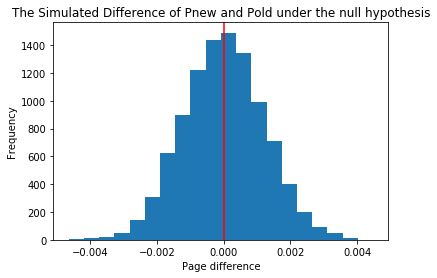

In [27]:
# Histogram of the p_diffs:
plt.hist(p_diffs, bins = 20)
# Converting the list into a numpy array for applying methods local to np.array objects
p_diffs_array = np.array(p_diffs)
# Labels and all
plt.axvline(x = (p_diffs_array.mean()), linewidth = 1.5, color = 'r')
plt.title("The Simulated Difference of Pnew and Pold under the null hypothesis")
plt.xlabel("Page difference")
plt.ylabel("Frequency");

> You can observe how this follows a <b>normal distribution</b> with a mean of 0.

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [28]:
actual_diffs = df2[df2['group'] == 'treatment']['converted'].mean() - df2[df2['group'] == 'control']['converted'].mean()
(p_diffs > actual_diffs).mean()

0.90329999999999999

> The proportion is ~91%.

k. In words, explain what you just computed in part **j.**.  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

> The value computed in part j is called the <b>p-value</b> in scientific terms. 

> This basically means that provided the null hypothesis is indeed true, and given our alpha at 0.05 (or 5%), this value calculated here is extremely large which provides us "evidence" in favor of the null hypothesis i.e. $P_{new}$ - $P_{old}$ <= 0.

> This means that there isn't enough evidence for us to suggest that there is a difference between the new and the old pages. Hence, we fail to reject the null hypothesis.

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [29]:
import statsmodels.api as sm

convert_old = df2[df2['group'] == 'control']['converted'].sum()
convert_new = df2[df2['group'] == 'treatment']['converted'].sum()

n_old = df2[df2['landing_page'] == 'old_page'].shape[0]
n_new = df2[df2['landing_page'] == 'new_page'].shape[0]

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


> The no. of conversions for the old page is 17489 and for the new page is 17264.

> The no. of individuals who received each page are 145274 (old) and 145310 (new).

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [30]:
# Computing the z statistic and the p-value
z_score, p_value = sm.stats.proportions_ztest([convert_new, convert_old], [n_new, n_old])
z_score

-1.3109241984234394

In [31]:
p_value

0.18988337448195103

> Therefore, the z-stat is -1.3109 and the p_value is 0.1899.

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

In [32]:
from scipy.stats import norm

# Calculating z-critical value at alpha = 0.05
norm.ppf(1-(0.05))

1.6448536269514722

> At a significance level of 95% for a right-tailed hypothesis (since $P_{new}$ > $P_{old}$), the z-critical value is 1.64. 

> With a large p-value and the z-score not exceeding 1.644, we fail to reject the null hypothesis. 

> The results <b>agree</b> with findings in part j. and k. - the difference between the old and the new page is not statistically significant.

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

> Since this is a clear case of binary classification, I would go with a <b>Binary Logistic Regression</b> although there may be other techniques like LDA or a Perceptron for this kind of a problem.

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a colun for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [33]:
# Importing the relevant library
import statsmodels.api as sm

# Adding a new column - intercept
df2['intercept'] = 1

# Creating the dummies
df2[['treatment', 'control']] = pd.get_dummies(df2['group'])
df2['ab_page'] = df2['treatment']

c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [34]:
# Building the logistic regression model with converted, intercept and ab_page variables
logreg_model = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])

# Fitting the model
fitted_model = logreg_model.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [35]:
# Summary of the model
fitted_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Tue, 20 Nov 2018   Pseudo R-squ.:               8.077e-06
Time:                        20:12:45   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0038      0.008   -247.146      0.000      -2.020      -1.988
ab_page        0.0150      0.011      1.311      0.190      -0.007       0.037
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in the **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in the **Part II**?

> The p-value associated with the ab_page is <b>0.190</b>. It is pretty large compared to our significance level of 0.05 or 5%.

> This differs from the value found in Part II because the underlying assumptions for the Hypothesis Testing earlier and the Regression Test now are different and, therefore, the hypotheses are different. This regression assumes a two-tailed hypothesis i.e. $H_{0}$: $P_{new}$ - $P_{old}$ = 0 and $H_{1}$: $P_{new}$ =/= $P_{old}$ whereas our initial test assumed a right-tailed hypothesis wherein the alternate hypothesis was $H_{1}$: $P_{new}$ > $P_{old}$

> It is important to note however that the differnce in the p-values is minuscule and therefore, we still retain the null hypothesis to be true. 

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

> <b>Adding Other Variables - Advantages</b>
>> Given that this regression relies only on one variable to make predictions, it would be prudent to investigate and maybe add other variables to the model to see if it improves the model. Having very few or only one variable for a model makes it a <b>high-bias, low-variance</b> model. However, the performance of the model may not be affected a lot if the choice of the variables have been accurate given the context. 

>> In this scenario, since we are trying to model human perception of two landing pages, addition of newer/more variables might help the model with the classification since human perception is not a very simple notion i.e. it may not be a function of only
one variable.

> <b>Adding Other Variables - Disadvantages</b>
>> Addition of other variables might reduce the bias, however, it may lead to a <b>high-variance, low-bias</b> model if executed improperly. Ideally, you only want variables that impact your classification by a lot as opposed to adding any innocuous variable just to increase the number of predictors indiscriminately.

> In summary, the bias-variance trade-off needs to be considered since the model you are creating needs to be generalizable and it should be able to pick up the underlying pattern. Else it might perform well when training and then provide spurious results when put to the test. 


g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy varaibles.** Provide the statistical output as well as a written response to answer this question.

In [38]:
# Reading in the new file
countries = pd.read_csv('countries.csv')

# Viewing the new df
countries.head()


,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [47]:
# Joining the tables
df3 = countries.set_index('user_id').join(df2.set_index('user_id'), how='inner')

# View the new dataset
df3.head()

,country,timestamp,group,landing_page,converted,intercept,treatment,control,ab_page
user_id,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,1,0,1
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,0,1,0
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,0,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,1,0,1
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,0,1,0


In [48]:
# Creating dummy variables
df3[['UK', 'US', 'CA']] = pd.get_dummies(df3['country'])

df3.head()

,country,timestamp,group,landing_page,converted,intercept,treatment,control,ab_page,UK,US,CA
user_id,,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,1,0,1,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,0,1,0,0,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,0,1,0,0,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,1,0,1,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,0,1,0,0,1,0


In [64]:
# Creating the second model
logreg_model2 = sm.Logit(df3['converted'], df3[['intercept', 'UK', 'US']])

# Fitting the model
fitted_model2 = logreg_model2.fit()

# Summary of the new model
fitted_model2.summary()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Tue, 20 Nov 2018   Pseudo R-squ.:               1.521e-05
Time:                        20:22:08   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1984
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9967      0.007   -292.314      0.000      -2.010      -1.983
UK            -0.0408      0.027     -1.518      0.129      -0.093       0.012
US             0.0099      0.013      0.746      0.456      -0.016       0.036
==============================================================================
"""

> It appears that adding countries alone <b>did not</b> have a statistically significant impact on our model given that the p-values for both are well above our alpha of 0.05. Perhaps a combination approach with the ab_page as well as the countries might yield a different result.

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [68]:
# Creating the third model with both ab_page and the countries
logreg_model3 = sm.Logit(df3['converted'], df3[['intercept', 'UK', 'US', 'ab_page']])

# Fitting this new model
fitted_model3 = logreg_model3.fit()

# Summary of the model
fitted_model3.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Tue, 20 Nov 2018   Pseudo R-squ.:               2.323e-05
Time:                        20:25:48   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0042      0.009   -224.560      0.000      -2.022      -1.987
UK            -0.0408      0.027     -1.516      0.130      -0.093       0.012
US             0.0099      0.013      0.743      0.457      -0.016       0.036
ab_page        0.0149      0.011      1.307      0.191      -0.007       0.037
==============================================================================
"""

> Despite adding the other variable, the model seems to have remained unchanged with p-values greater than 5%. This means we fail to reject the null hypothesis, confirming our initial results from Part II and the previous logistic regression models.

> The interaction between the country and page did not have any statistically significant impact on the result of the new model.

<a id='conclusions'></a>
## Conclusions

> In conclusion, we can state that there is not enough evidence to support whether the new page did better in terms of converting users than the old page.

> We can conclude this through the two-pronged approach we took, both in Part II and in Part III. 

> Additionally, through our logistic regression analysis, we figured that countries did not change our minds about the null hypothesis so we failed to reject it (despite multiple attempts!). There is definitely a difference in the model when accounting for more variables, however, they are not enough to significantly impact our results. 

> <b>Recommendation</b>
>> Based on our study, it would be wise for the e-commerce company to continue changing the UI/UX of the new page before running this trial once again. As of now, however, sticking to the old page is good enough.

## References

> http://knowledgetack.com/python/statsmodels/proportions_ztest/

> Special thanks to SThornewillvE (https://github.com/SThornewillvE) and Carly Hochreiter (https://carly-data.com)

> http://blog.yhat.com/posts/logistic-regression-python-rodeo.html

> https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html

In [69]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0